Iteration 1/50
  Potential RMS change: 4.1565e-07 V
Converged after 1 iterations.

Converged Eigenenergies (eV):


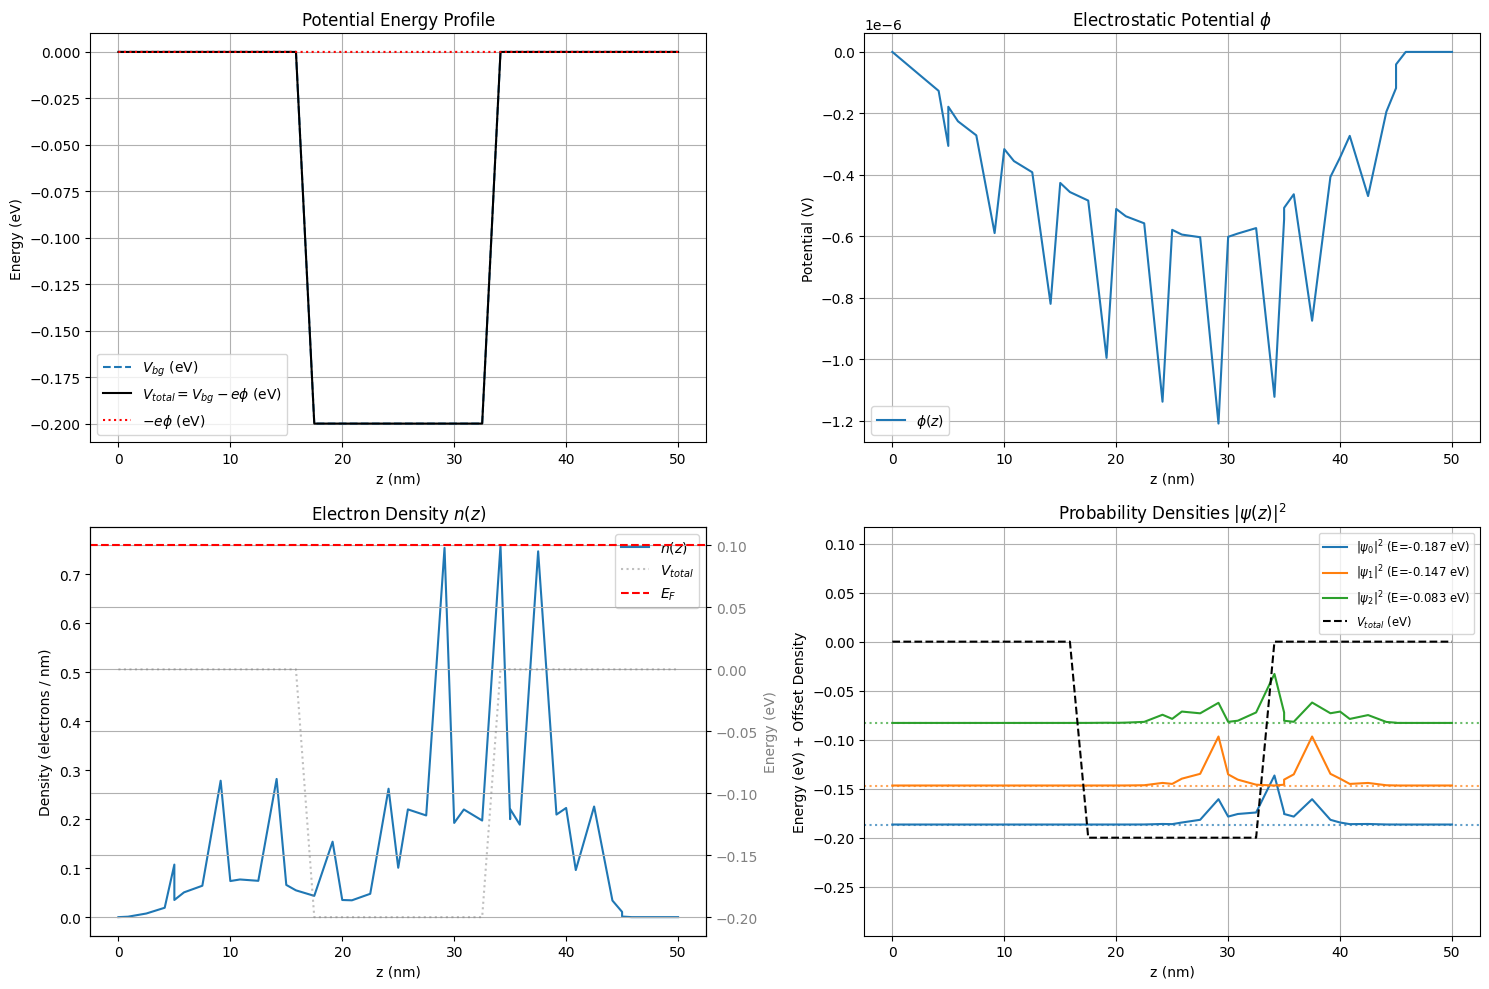

In [23]:
import numpy as np
from numpy.polynomial.legendre import leggauss, legval, legder
from scipy.linalg import eigh # Use eigh for Hermitian generalized eigenvalue problem
from scipy.constants import hbar, m_e, elementary_charge, epsilon_0
import matplotlib.pyplot as plt
import warnings

# --- Physical Constants ---
# Using effective mass of GaAs for example
m_eff = 0.067 * m_e
# Using relative permittivity of GaAs for example
eps_r = 12.9
eps = eps_r * epsilon_0
e = elementary_charge # Electron charge (positive value)

# --- Helper Functions (Minor modifications maybe needed) ---

def gauss_lobatto_legendre(N):
    """
    Computes Gauss-Lobatto-Legendre (GLL) points and weights on [-1, 1].
    N is the polynomial order (N+1 points).
    """
    if N == 0: # Special case for 1 point (midpoint) - unlikely useful for SEM
        return np.array([0.0]), np.array([2.0])
    if N == 1:
        return np.array([-1.0, 1.0]), np.array([1.0, 1.0])

    # Use leggauss for N-1 points interior points (order N-2 polynomial exact)
    points_gauss, weights_gauss = leggauss(N) # N points for Gauss-Legendre

    # The GLL points are -1, 1, and the roots of L'_N(x)
    # Alternatively, construct Jacobi matrix for L_N' and find eigenvalues
    # Or use a known formula/approximation if available.
    # Let's stick to a common definition: Use roots of L'_{N-1}(x) ? No, roots of (1-x^2)P'_N(x)
    # Simpler numerical approach often uses Golub-Welsch for Gauss, then finds Lobatto
    # For simplicity here, let's use a common implementation source if numpy doesn't provide directly
    # --- Approximation using Gauss points ---
    # This approximation is NOT generally correct for GLL points.
    # Correct GLL points are roots of (1-x^2) * P'_N(x) where P_N is Legendre poly of order N
    # Let's find roots of P'_{N}(x) for interior points.
    # P'_N(x) roots are needed. legder(P_N) coefficients
    c_n = np.zeros(N + 1)
    c_n[N] = 1
    c_n_prime = legder(c_n)
    # Find roots of the derivative polynomial
    points_interior = np.polynomial.legendre.legroots(c_n_prime)
    points = np.concatenate(([-1.0], np.sort(points_interior), [1.0]))

    # Weights calculation
    weights = np.zeros(N + 1)
    pN_at_points = legval(points, c_n)
    weights = 2.0 / (N * (N + 1) * pN_at_points**2)
    weights[0] = 2.0 / (N * (N + 1))
    weights[-1] = 2.0 / (N * (N + 1))

    # Check numpy version >= 1.23 for potential built-in leggauss changes or alternatives
    # If using an older version, a dedicated GLL function might be needed from libraries like Nektar++, Semtex, etc.
    # Or implement root-finding for (1-x^2)P'_N(x) explicitly.
    # For now, using this calculated version. Validate if possible.
    if len(points) != N + 1:
         warnings.warn(f"GLL point calculation might be approximate for N={N}. Expected {N+1} points, got {len(points)}.")
         # Fallback for simple cases if calculation fails
         if N==2: points = np.array([-1, 0, 1])
         elif N==3: points = np.array([-1, -np.sqrt(1/5), np.sqrt(1/5), 1])
         elif N==4: points = np.array([-1, -np.sqrt(3/7), 0, np.sqrt(3/7), 1])
         # Recalculate weights if fallback used (using standard formulas)
         if N==2: weights = np.array([1/3, 4/3, 1/3])
         elif N==3: weights = np.array([1/6, 5/6, 5/6, 1/6])
         elif N==4: weights = np.array([1/10, 49/90, 32/45, 49/90, 1/10])


    # Final check
    if len(points) != N+1 or len(weights) != N+1:
        raise ValueError(f"Failed to compute correct number of GLL points/weights for N={N}")


    return points, weights

def map_gll_points(z_start, z_end, z_local):
    """Maps GLL points from [-1, 1] to [z_start, z_end]."""
    return (z_end + z_start) / 2.0 + (z_end - z_start) / 2.0 * z_local

def legendre_basis_and_derivs(N, z_local):
    """
    Computes the Lagrange basis polynomials (associated with GLL points)
    and their derivatives on the reference element [-1, 1].

    Args:
        N (int): Polynomial order (N+1 points).
        z_local (ndarray): GLL points on [-1, 1]. Shape (N+1,).

    Returns:
        tuple:
            basis (ndarray): Basis functions evaluated at GLL points. Shape (N+1, N+1). basis[i, j] = L_j(z_i).
            derivs (ndarray): Basis function derivatives evaluated at GLL points. Shape (N+1, N+1). derivs[i, j] = L'_j(z_i).
    """
    num_points = N + 1
    basis = np.zeros((num_points, num_points))
    derivs = np.zeros((num_points, num_points))
    z_gll = z_local # Use the provided GLL points

    for j in range(num_points): # Basis function index
        # Construct Lagrange polynomial L_j(z) which is 1 at z_j and 0 at other z_k
        coeffs = np.zeros(num_points)
        coeffs[j] = 1.0
        poly = np.polyfit(z_gll, coeffs, N) # Find polynomial coeffs
        poly_der = np.polyder(poly)

        basis[:, j] = np.polyval(poly, z_gll)
        derivs[:, j] = np.polyval(poly_der, z_gll)

        # Verification (optional): Check if basis[i, j] approx delta_ij
        # Numerical precision might affect this, especially for high N
        # print(f"Basis check j={j}: {np.round(basis[:, j], 3)}")


    # Ensure near-zero values are zeroed out due to potential precision issues
    basis[np.abs(basis) < 1e-10] = 0.0
    derivs[np.abs(derivs) < 1e-10] = 0.0

    return basis, derivs


def assemble_element_matrices(N, z_start, z_end, V_local, params):
    """
    Assembles the element stiffness (A) and mass (B) matrices for Schrödinger,
    and stiffness matrix (A_poisson) for Poisson.

    Args:
        N (int): Polynomial order.
        z_start, z_end (float): Element boundaries.
        V_local (ndarray): Potential evaluated at the GLL points of this element. Shape (N+1,).
        params (dict): Simulation parameters including physical constants.

    Returns:
        tuple: A_element, B_element, A_poisson_element
    """
    num_points = N + 1
    z_local, w_local = gauss_lobatto_legendre(N) # Points/weights on [-1, 1]
    z_global_element = map_gll_points(z_start, z_end, z_local) # GLL points in global coords for this element
    basis, derivs_local = legendre_basis_and_derivs(N, z_local) # Basis/Derivs evaluated at z_local

    # Jacobian of the transformation z_global = map(z_local)
    # dz_global / dz_local = (z_end - z_start) / 2
    jacobian = (z_end - z_start) / 2.0

    # Derivatives in global coordinates: d/dz_global = (d/dz_local) * (dz_local / dz_global)
    derivs_global = derivs_local / jacobian

    # Get physical constants
    hbar = params['hbar']
    m_eff = params['m_eff']
    eps = params['eps'] # Permittivity epsilon = eps_r * eps_0

    # Initialize element matrices
    A_element = np.zeros((num_points, num_points)) # Schrodinger Stiffness
    B_element = np.zeros((num_points, num_points)) # Schrodinger Mass
    A_poisson_element = np.zeros((num_points, num_points)) # Poisson Stiffness

    # Integration loop over GLL points (index l)
    for l in range(num_points):
        w_gll_global = w_local[l] * jacobian # Weight in global coords
        for i in range(num_points): # Basis function index (row)
            for j in range(num_points): # Basis function index (col)
                # Schrodinger Matrices
                # A = integral[ (hbar^2 / 2m) * (d(psi_i)/dz * d(psi_j)/dz) + V(z) * psi_i * psi_j ] dz
                kinetic_term = (hbar**2 / (2 * m_eff)) * derivs_global[l, i] * derivs_global[l, j]
                potential_term = V_local[l] * basis[l, i] * basis[l, j]
                A_element[i, j] += (kinetic_term + potential_term) * w_gll_global

                # B = integral[ psi_i * psi_j ] dz
                B_element[i, j] += basis[l, i] * basis[l, j] * w_gll_global

                # Poisson Matrix
                # A_poisson = integral[ epsilon * (d(phi_i)/dz * d(phi_j)/dz) ] dz
                A_poisson_element[i, j] += eps * derivs_global[l, i] * derivs_global[l, j] * w_gll_global

    return A_element, B_element, A_poisson_element


def assemble_global_matrices(element_matrices, K, N):
    """
    Assembles the global matrices from element matrices using direct stiffness summation.

    Args:
        element_matrices (list): List of tuples [(A_elem, B_elem, A_poisson_elem), ...].
        K (int): Number of elements.
        N (int): Polynomial order (N+1 points per element).

    Returns:
        tuple: A_global, B_global, A_poisson_global
    """
    num_points_element = N + 1
    # Total number of unique GLL nodes = K * N + 1
    global_size = K * N + 1

    A_global = np.zeros((global_size, global_size))
    B_global = np.zeros((global_size, global_size))
    A_poisson_global = np.zeros((global_size, global_size))

    for k in range(K): # Loop over elements
        A_elem, B_elem, A_poisson_elem = element_matrices[k]

        # Map local element node indices (0 to N) to global node indices
        # Node i in element k corresponds to global index k*N + i
        for i_local in range(num_points_element):
            i_global = k * N + i_local
            for j_local in range(num_points_element):
                j_global = k * N + j_local

                # Add element contribution to global matrices
                A_global[i_global, j_global] += A_elem[i_local, j_local]
                B_global[i_global, j_global] += B_elem[i_local, j_local]
                A_poisson_global[i_global, j_global] += A_poisson_elem[i_local, j_local]

    return A_global, B_global, A_poisson_global

def apply_boundary_conditions(A, B, f, bc_type='dirichlet', bc_value=0.0):
    """
    Applies boundary conditions to global matrices and optionally a load vector.
    Modifies A, B, f in place. Simplistic Dirichlet for now.
    Sets boundary rows/cols to 0, diagonal to 1, RHS to bc_value.

    Args:
        A, B: Global matrices.
        f: Global load vector (or None if not needed).
        bc_type: Type of BC ('dirichlet').
        bc_value: Value for Dirichlet BC.
    """
    if bc_type.lower() != 'dirichlet':
        raise NotImplementedError("Only Dirichlet BCs are implemented.")

    global_size = A.shape[0]
    indices_to_modify = [0, global_size - 1] # First and last nodes

    # Make sure the matrix is not too small for this BC type
    if global_size < 2 and len(indices_to_modify) > 0:
         warnings.warn("Matrix size is too small to apply boundary conditions to first and last nodes.")
         indices_to_modify = [] # Don't apply if size is 1

    # Store original A columns for potential RHS adjustment if bc_value != 0
    A_original_cols = {}
    if f is not None and not np.isclose(bc_value, 0.0):
        for idx in indices_to_modify:
            if idx < global_size and A is not None:
                 A_original_cols[idx] = A[:, idx].copy()


    for idx in indices_to_modify: # Use lowercase 't'
        # Ensure index is within bounds (relevant if matrix size is 1)
        if idx >= global_size:
             continue

        # --- Modify Matrices ---
        # Zero out rows and columns first
        if A is not None:
            A[idx, :] = 0.0
            A[:, idx] = 0.0
        if B is not None:
            B[idx, :] = 0.0
            B[:, idx] = 0.0 # Important for generalized eigenvalue problem

        # Set diagonal elements
        if A is not None:
            A[idx, idx] = 1.0
        if B is not None:
            # For A*psi = E*B*psi, setting B[idx,idx]=1.0 keeps B positive definite
            # for solvers like eigh, while A enforces the boundary condition.
            B[idx, idx] = 1.0 # ***** CORRECTION HERE *****

        # --- Modify Load Vector f (if provided, e.g., for Poisson) ---
        if f is not None:
            # Adjust entries f[i] for i != idx FIRST, only if bc_value is non-zero
            if not np.isclose(bc_value, 0.0) and idx in A_original_cols:
                 # f_new[i] = f_old[i] - A_original[i, idx] * bc_value
                 f -= A_original_cols[idx] * bc_value
                 # We corrected the whole vector, now set the BC row correctly:
                 f[idx] = bc_value # Since A[idx,idx]=1, A[idx,j]=0 -> 1*x[idx]=bc_value
            else:
                 # If bc_value is 0, just set f[idx]=0
                 f[idx] = 0.0 # Since A[idx,idx]=1 -> 1*x[idx]=0


def solve_schrodinger(A_schrodinger, B_schrodinger, num_eigenvalues):
    """Solves the generalized eigenvalue problem A*psi = E*B*psi."""
    # Need to handle the zero rows/cols from BCs carefully.
    # Option 1: Solve the full system, eigenvalues corresponding to BCs might be inf/nan or large.
    # Option 2: Reduce the system by removing rows/cols corresponding to BCs.

    # Let's try Option 1 first, using eigh which expects Hermitian matrices.
    # A and B should be symmetric if V is real.
    try:
        # eigh handles generalized eigenvalue problem A x = lambda B x
        # Returns eigenvalues in ascending order.
        eigenvalues, eigenvectors = eigh(A_schrodinger, B_schrodinger)

        # Select the lowest 'num_eigenvalues'
        # Filter out potential non-physical eigenvalues resulting from BC modification if needed
        # Often, the eigenvalues corresponding to fixed BCs become very large or ill-defined.
        # Sort and select the lowest physically meaningful ones.
        valid_indices = np.where(np.isfinite(eigenvalues))[0]
        eigenvalues = eigenvalues[valid_indices]
        eigenvectors = eigenvectors[:, valid_indices]

        sort_indices = np.argsort(eigenvalues)
        eigenvalues = eigenvalues[sort_indices]
        eigenvectors = eigenvectors[:, sort_indices]

        if len(eigenvalues) < num_eigenvalues:
            warnings.warn(f"Requested {num_eigenvalues} eigenvalues, but only found {len(eigenvalues)} finite ones.")
            num_eigenvalues = len(eigenvalues)

        return eigenvalues[:num_eigenvalues], eigenvectors[:, :num_eigenvalues]

    except np.linalg.LinAlgError as e:
        print(f"Eigenvalue solver failed: {e}")
        print("Check if B matrix is positive definite (excluding BC rows/cols).")
        # Consider reducing the system matrix before solving.
        return None, None


def solve_poisson(A_poisson, rho_global, z_gll_global, w_gll_global, basis_global, params):
    """
    Solves the Poisson equation A_poisson * phi = b_poisson.
    Calculates the load vector b_poisson from rho_global.
    """
    global_size = A_poisson.shape[0]
    e = params['e'] # Use charge magnitude

    # Calculate the load vector b_poisson = integral[ rho(z) * basis_i(z) ] dz
    # rho_global is the charge density evaluated at the global GLL points
    # basis_global[l, i] = basis_i(z_l) where z_l is the l-th global GLL point
    b_poisson = np.zeros(global_size)
    num_gll_global = len(z_gll_global)

    if len(rho_global) != num_gll_global:
         raise ValueError(f"rho_global size ({len(rho_global)}) must match number of global GLL points ({num_gll_global}).")

    # We need basis functions evaluated at ALL global GLL points
    # The basis_global passed should ideally be this: shape (num_gll_global, global_size)
    # Where basis_global[l, i] = phi_i(z_l) - the i-th global basis function at the l-th GLL point.
    # Let's assume basis_global is correctly structured.
    # Note: Constructing this full basis_global can be complex.
    # Alternative: Integrate element-wise.

    # --- Element-wise integration for load vector ---
    K = params['num_elements']
    N = params['polynomial_order']
    elements = np.linspace(params['domain'][0], params['domain'][1], K + 1)
    b_poisson = np.zeros(global_size)

    rho_at_gll = rho_global # Assuming rho is already evaluated at GLL points

    global_gll_idx = 0
    for k in range(K): # Loop elements
        z_start, z_end = elements[k], elements[k+1]
        z_local_ref, w_local_ref = gauss_lobatto_legendre(N)
        basis_ref, _ = legendre_basis_and_derivs(N, z_local_ref) # Lagrange basis on [-1, 1]
        jacobian = (z_end - z_start) / 2.0

        # Indices for GLL points belonging to this element in the global GLL array
        element_gll_indices = range(global_gll_idx, global_gll_idx + N + 1)
        # Indices for global basis functions (DOFs) associated with this element
        element_dof_indices = range(k*N, k*N + N + 1)

        for i_local in range(N + 1): # Loop over local basis functions (-> global DOFs)
            i_global = element_dof_indices[i_local]
            integrand = 0.0
            for l_local in range(N + 1): # Loop over GLL points within the element
                l_global = element_gll_indices[l_local]
                w_gll_global_pt = w_local_ref[l_local] * jacobian
                # basis_ref[l_local, i_local] is the value of local basis i at local point l
                integrand += (rho_at_gll[l_global] / params['eps']) * basis_ref[l_local, i_local] * w_gll_global_pt

            b_poisson[i_global] += integrand

        global_gll_idx += N # Move to start of next element's points (overlapping node)

    # --- Apply Boundary Conditions ---
    A_poisson_bc = A_poisson.copy()
    b_poisson_bc = b_poisson.copy()
    # Apply phi=0 at boundaries (modifies A and b)
    apply_boundary_conditions(A_poisson_bc, None, b_poisson_bc, bc_type='dirichlet', bc_value=0.0)

    # --- Solve Linear System ---
    try:
        phi_coeffs = np.linalg.solve(A_poisson_bc, b_poisson_bc)
        # The result phi_coeffs contains the potential values at the global node points
        return phi_coeffs
    except np.linalg.LinAlgError as e:
        print(f"Poisson solver failed: {e}")
        # Could indicate singular matrix after BCs, check BC implementation or matrix assembly.
        # Try pseudo-inverse?
        try:
            print("Trying pseudo-inverse...")
            phi_coeffs = np.linalg.pinv(A_poisson_bc) @ b_poisson_bc
            # Check if solution makes sense, pinv might give least-squares solution
            return phi_coeffs
        except Exception as e_pinv:
             print(f"Pseudo-inverse also failed: {e_pinv}")
             return np.zeros_like(b_poisson) # Return zero potential on failure

def calculate_charge_density(eigenvectors, eigenvalues, E_F, T, z_gll_global, w_gll_global, basis_global, B_global, params):
    """
    Calculates the electron charge density rho(z) = -e * n(z).
    Uses zero-temperature approximation for simplicity first.
    Requires properly normalized wavefunctions.
    """
    e = params['e']
    m_eff = params['m_eff']
    hbar = params['hbar']
    k_B = 1.380649e-23 # Boltzmann constant (use scipy.constants later if needed)
    global_size = B_global.shape[0]
    num_gll_global = len(z_gll_global)

    # Eigenvectors from `eigh(A, B)` are typically B-orthonormal: psi_i^T B psi_j = delta_ij
    # Let psi(z) = sum_k c_k * basis_k(z), where c is the eigenvector.
    # We need |psi(z)|^2 at the GLL points.

    # Assuming basis_global[l, k] = basis_k(z_l) -> value of k-th basis function at l-th GLL point
    # psi_i(z_l) = sum_k eigenvectors[k, i] * basis_global[l, k]

    # Check basis_global shape
    if basis_global.shape != (num_gll_global, global_size):
         raise ValueError(f"basis_global shape {basis_global.shape} incorrect. Expected ({num_gll_global}, {global_size}).")

    electron_density_n = np.zeros(num_gll_global) # n(z) at GLL points

    num_states = len(eigenvalues)
    wavefuncs_at_gll = np.zeros((num_gll_global, num_states))

    for i in range(num_states): # Loop over eigenstates
        # Calculate wavefunction values at GLL points
        psi_i_coeffs = eigenvectors[:, i]
        psi_i_values = basis_global @ psi_i_coeffs # Shape (num_gll_global,)
        wavefuncs_at_gll[:, i] = psi_i_values

        # Normalize wavefunction using mass matrix B (check if eigh already did B-normalization)
        # norm_sq = psi_i_coeffs.T @ B_global @ psi_i_coeffs
        # If norm_sq is close to 1, normalization is likely correct.
        # print(f"State {i} norm^2 = {norm_sq}") # Debug
        # if abs(norm_sq - 1.0) > 1e-6:
        #     warnings.warn(f"Wavefunction {i} might not be B-normalized (norm^2={norm_sq}). Normalizing.")
        #     psi_i_coeffs /= np.sqrt(norm_sq)
        #     psi_i_values /= np.sqrt(norm_sq) # Renormalize values too

        # Zero-Temperature Fermi-Dirac factor
        if eigenvalues[i] < E_F:
            fermi_factor = 1.0
        else:
            fermi_factor = 0.0

        # If Temperature T > 0:
        # if T > 1e-6: # Avoid division by zero if T=0
        #     exponent = (eigenvalues[i] - E_F) / (k_B * T)
        #     # Cap exponent to avoid overflow
        #     max_exponent = 700 # exp(700) is near float limit
        #     if exponent > max_exponent:
        #         fermi_factor = 0.0
        #     elif exponent < -max_exponent:
        #         fermi_factor = 1.0
        #     else:
        #         fermi_factor = 1.0 / (1.0 + np.exp(exponent))
        # else: # T=0 case handled above

        # Add contribution to density: n(z) = sum_i |psi_i(z)|^2 * f(E_i)
        # We need |psi_i(z_l)|^2
        electron_density_n += np.abs(psi_i_values)**2 * fermi_factor


    # Charge density rho = -e * n
    charge_density_rho = -e * electron_density_n
    return charge_density_rho, wavefuncs_at_gll


def define_background_potential(z, params):
    """Defines the background potential V_bg(z) representing the device structure."""
    # Example: Simple Nanowire with Source/Drain and a Gate-induced Well
    domain = params['domain']
    L = domain[1] - domain[0]
    center = (domain[1] + domain[0]) / 2.0
    well_width = L / 3.0
    barrier_height = 0.0 # Conduction band edge energy (eV) - use 0 as reference
    well_depth = 0.2 * e # 0.2 eV deep well

    V_bg = np.full_like(z, barrier_height) # Start with flat potential

    # Define well region
    well_start = center - well_width / 2.0
    well_end = center + well_width / 2.0
    well_indices = (z >= well_start) & (z <= well_end)
    V_bg[well_indices] = barrier_height - well_depth

    # Smooth potential edges (optional, using sigmoid)
    # smooth_width = L / 50.0
    # V_bg = barrier_height - well_depth / (1 + np.exp((z - well_start)/smooth_width)) # Left edge
    # V_bg += well_depth / (1 + np.exp((z - well_end)/smooth_width)) # Right edge correction

    return V_bg

def build_global_basis_at_gll(z_gll_global, K, N, elements):
    """
    Constructs the global basis functions evaluated at all global GLL points.
    Returns basis_global[l, i] = phi_i(z_l), where phi_i is the i-th global basis function
    and z_l is the l-th global GLL point.
    """
    num_gll_global = len(z_gll_global)
    global_size = K * N + 1
    basis_global_at_gll = np.zeros((num_gll_global, global_size))

    global_gll_idx = 0
    for k in range(K): # Iterate over elements
        z_start, z_end = elements[k], elements[k+1]
        z_local_ref, _ = gauss_lobatto_legendre(N)
        basis_ref, _ = legendre_basis_and_derivs(N, z_local_ref) # Lagrange basis on [-1, 1]

        # GLL points for this element in global coordinates
        element_gll_indices_global = range(global_gll_idx, global_gll_idx + N + 1)
        # Global DOF indices associated with this element
        element_dof_indices = range(k*N, k*N + N + 1)

        for i_local in range(N + 1): # Local basis index
            i_global = element_dof_indices[i_local] # Corresponding global DOF index
            for l_local in range(N + 1): # Local GLL point index
                l_global = element_gll_indices_global[l_local] # Corresponding global GLL point index
                # basis_ref[l_local, i_local] is the value of local basis 'i' at local point 'l'
                # This value contributes to the global basis function 'i_global' at the global point 'l_global'
                # Since Lagrange basis is used, element basis functions directly map to global basis functions
                # Add contribution (handles overlap automatically because basis_ref is zero at other nodes)
                basis_global_at_gll[l_global, i_global] += basis_ref[l_local, i_local]

        global_gll_idx += N # Move to next element's starting point index

    # Verify normalization/correctness (optional)
    # row_sums = np.sum(basis_global_at_gll, axis=1) # Sum over basis functions should be 1 at each point
    # if not np.allclose(row_sums, 1.0):
    #     warnings.warn(f"Sum of basis functions is not 1 everywhere. Max deviation: {np.max(np.abs(row_sums - 1.0))}")

    return basis_global_at_gll


# --- Main Simulation Function ---

def schrodinger_poisson_sem_self_consistent(params):
    """
    Solves the 1D Schrödinger-Poisson system self-consistently using SEM.

    Args:
        params (dict): Parameters for the simulation.

    Returns:
        tuple: Converged results: eigenenergies, wavefunctions_coeffs, wavefuncs_at_gll, phi, rho, V_total, z_global_nodes, z_gll_global
    """

    # --- Setup ---
    K = params['num_elements']
    N = params['polynomial_order'] # N+1 points per element
    domain = params['domain']
    E_F = params['fermi_level'] * e # Convert eV to Joules
    T = params['temperature'] # Kelvin
    max_iterations = params.get('max_iterations', 100)
    convergence_threshold = params.get('convergence_threshold', 1e-5) # Threshold on potential change (Volts)
    mixing_alpha = params.get('mixing_alpha', 0.1) # Mixing parameter for potential update

    # --- Discretization ---
    # Element boundaries
    elements = np.linspace(domain[0], domain[1], K + 1)
    # Global node points (where basis functions are centered, endpoints of elements overlap)
    z_global_nodes = np.linspace(domain[0], domain[1], K * N + 1)
    global_size = len(z_global_nodes)

    # Global GLL points and weights (needed for integration and function evaluation)
    z_gll_global = []
    w_gll_global = []
    z_local_ref, w_local_ref = gauss_lobatto_legendre(N)
    global_gll_idx_map = {} # Map global GLL index to (element_k, local_gll_idx)
    count = 0
    for k in range(K):
        z_start, z_end = elements[k], elements[k+1]
        jacobian = (z_end - z_start) / 2.0
        z_mapped = map_gll_points(z_start, z_end, z_local_ref)
        w_mapped = w_local_ref * jacobian
        # Add points, avoiding double counting of element boundary nodes
        if k == 0:
            z_gll_global.extend(z_mapped)
            w_gll_global.extend(w_mapped)
            for l in range(N + 1): global_gll_idx_map[count + l] = (k, l)
            count += N + 1
        else:
            z_gll_global.extend(z_mapped[1:]) # Skip the first point (already added)
            w_gll_global.extend(w_mapped[1:]) # Skip weight? No, weights are specific to the point
            # Need careful handling of weights if points are merged.
            # Let's keep all points for now, makes indexing simpler
            # Revisit weight merging if needed for strict integration rules.
            for l in range(1, N + 1): global_gll_idx_map[count + l -1] = (k, l)
            count += N


    # Let's redefine z_gll_global simply by concatenating unique points
    z_gll_global = np.unique(np.concatenate([ map_gll_points(elements[k], elements[k+1], z_local_ref) for k in range(K)]))
    num_gll_global = len(z_gll_global)
    # Weights are harder to merge. Sticking to element-wise integration is safer.

    # Pre-compute global basis functions evaluated at global GLL points
    basis_global_at_gll = build_global_basis_at_gll(z_gll_global, K, N, elements)

    # --- Initial Guess ---
    phi = np.zeros(global_size) # Initial guess for electrostatic potential coefficients (at nodes)
    V_background = define_background_potential(z_gll_global, params) # Background potential at GLL points

    # --- Self-Consistent Loop ---
    for iteration in range(max_iterations):
        print(f"Iteration {iteration + 1}/{max_iterations}")

        # 1. Calculate Total Potential V_total = V_background - e * phi
        # We need V_total at the GLL points for element matrix assembly
        # Interpolate phi (defined at nodes) to GLL points
        phi_at_gll = basis_global_at_gll @ phi
        V_total_at_gll = V_background - e * phi_at_gll

        # 2. Assemble Element Matrices for Schrödinger and Poisson
        element_matrices = []
        global_gll_idx = 0
        for k in range(K):
            z_start, z_end = elements[k], elements[k + 1]
            # Get V_total for the GLL points within this element
            # Indices of GLL points belonging to element k
            element_gll_indices_global = np.where( (z_gll_global >= z_start) & (z_gll_global <= z_end) )[0]
            # Need exactly N+1 points per element. The simple slicing assumes non-unique boundaries.
            # Let's use the mapping logic
            current_element_gll_indices = []
            if k == 0:
                 current_element_gll_indices = list(range(N+1))
            else:
                 # Get the global index of the start node (which is the end node of prev element)
                 start_node_idx = np.where(np.isclose(z_gll_global, z_start))[0][0]
                 current_element_gll_indices = [start_node_idx] + list(range(start_node_idx + 1, start_node_idx + N + 1))

            if len(current_element_gll_indices) != N+1:
                 # Fallback if indexing is complex
                 z_local_ref_pts, _ = gauss_lobatto_legendre(N)
                 z_global_element_pts = map_gll_points(z_start, z_end, z_local_ref_pts)
                 # Find indices of these points in the global GLL array (requires tolerance)
                 indices_in_global = [np.where(np.isclose(z_gll_global, pt))[0][0] for pt in z_global_element_pts]
                 current_element_gll_indices = indices_in_global


            V_local = V_total_at_gll[current_element_gll_indices]

            A_elem, B_elem, A_poisson_elem = assemble_element_matrices(N, z_start, z_end, V_local, params)
            element_matrices.append((A_elem, B_elem, A_poisson_elem))

        # 3. Assemble Global Matrices
        A_schrodinger, B_schrodinger, A_poisson = assemble_global_matrices(element_matrices, K, N)

        # 4. Apply Boundary Conditions (Schrödinger: psi=0)
        A_schrodinger_bc = A_schrodinger.copy()
        B_schrodinger_bc = B_schrodinger.copy()
        apply_boundary_conditions(A_schrodinger_bc, B_schrodinger_bc, None, bc_type='dirichlet', bc_value=0.0)

        # 5. Solve Schrödinger Equation
        num_eigenvalues = params.get('num_eigenvalues', 10) # Number of states to compute
        eigenvalues, eigenvectors = solve_schrodinger(A_schrodinger_bc, B_schrodinger_bc, num_eigenvalues)

        if eigenvalues is None:
            print("Schrödinger solver failed. Aborting.")
            return None # Or handle error appropriately

        # 6. Calculate Charge Density
        # Need B_global without BCs applied for normalization check if needed
        # Use B_schrodinger here.
        rho_at_gll, wavefuncs_at_gll = calculate_charge_density(
            eigenvectors, eigenvalues, E_F, T,
            z_gll_global, w_gll_global, basis_global_at_gll, B_schrodinger, params
        )

        # 7. Solve Poisson Equation
        phi_new_coeffs = solve_poisson(A_poisson, rho_at_gll, z_gll_global, w_gll_global, basis_global_at_gll, params)

        # 8. Check Convergence and Mix Potential
        delta_phi = np.linalg.norm(phi_new_coeffs - phi) / np.sqrt(len(phi)) # RMS change
        print(f"  Potential RMS change: {delta_phi:.4e} V")

        if delta_phi < convergence_threshold:
            print(f"Converged after {iteration + 1} iterations.")
            phi = phi_new_coeffs # Use the converged potential
            break

        # Apply mixing
        phi = mixing_alpha * phi_new_coeffs + (1 - mixing_alpha) * phi

    else: # Loop finished without break
        warnings.warn(f"Self-consistent loop did not converge within {max_iterations} iterations.")
        # Return the last calculated values

    # --- Post-processing ---
    # Final potential at nodes and GLL points
    phi_converged_coeffs = phi
    phi_converged_at_gll = basis_global_at_gll @ phi_converged_coeffs
    V_total_converged_at_gll = V_background - e * phi_converged_at_gll
    rho_converged_at_gll = rho_at_gll # Density from last iteration

    # Convert energies from Joules to eV for easier interpretation
    eigenenergies_ev = eigenvalues / e

    # Return relevant results
    return (eigenenergies_ev, eigenvectors, wavefuncs_at_gll,
            phi_converged_coeffs, phi_converged_at_gll, # ADDED HERE
            rho_converged_at_gll, V_total_converged_at_gll,
            z_global_nodes, z_gll_global)


# --- Example Usage ---
params = {
    'num_elements': 10,        # Number of spectral elements
    'polynomial_order': 4,     # Order N (N+1 points per element)
    'domain': [0, 50e-9],      # Simulation domain in meters (e.g., 50 nm)
    'num_eigenvalues': 5,      # Number of lowest eigenstates to calculate
    'fermi_level': 0.1,        # Fermi level in eV (relative to reference potential 0)
    'temperature': 300,        # Temperature in Kelvin (used if Fermi-Dirac implemented with T>0)
    'max_iterations': 50,
    'convergence_threshold': 1e-4, # Volts
    'mixing_alpha': 0.05,       # Smaller alpha for potentially better stability
    # Physical parameters (already defined globally, but could be passed here)
    'hbar': hbar,
    'm_eff': m_eff,
    'eps': eps,
    'e': e,
}

# Run the simulation
results = schrodinger_poisson_sem_self_consistent(params)

# --- Plotting ---
if results:
    # ADD phi_at_gll to the unpacked tuple
    (eigenenergies_ev, eigenvectors, wavefuncs_at_gll,
     phi_coeffs, phi_at_gll, # ADDED HERE
     rho_at_gll, V_total_at_gll,
     z_nodes, z_gll) = results

    print("\nConverged Eigenenergies (eV):")
    # ... print energies ...
    z_nodes_nm = z_nodes * 1e9
    z_gll_nm = z_gll * 1e9

    plt.figure(figsize=(15, 10))

    # Plot Potential Profile (CORRECTED LINE)
    plt.subplot(2, 2, 1)
    V_background = define_background_potential(z_gll, params) # Recalculate for plotting
    plt.plot(z_gll_nm, V_background / e, label='$V_{bg}$ (eV)', linestyle='--')
    plt.plot(z_gll_nm, V_total_at_gll / e, label='$V_{total} = V_{bg} - e\phi$ (eV)', color='k')
    # Use the returned phi_at_gll directly:
    plt.plot(z_gll_nm, -params['e'] * phi_at_gll / e, label='$-e\phi$ (eV)', color='r', linestyle=':') # CORRECTED
    plt.title("Potential Energy Profile")
    plt.xlabel("z (nm)")
    plt.ylabel("Energy (eV)")
    plt.legend()
    plt.grid(True)

    # Plot Electrostatic Potential phi (CORRECTED LINE)
    plt.subplot(2, 2, 2)
    # Use the returned phi_at_gll directly:
    plt.plot(z_gll_nm, phi_at_gll, label='$\phi(z)$') # CORRECTED
    # plt.plot(z_nodes_nm, phi_coeffs, 'o', label='$\phi$ (at nodes)') # uncomment to see node values
    plt.title("Electrostatic Potential $\phi$")
    plt.xlabel("z (nm)")
    plt.ylabel("Potential (V)")
    plt.legend()
    plt.grid(True)

    # Plot Charge Density
    plt.subplot(2, 2, 3)
    # Convert rho from C/m^3 to electrons/nm^3 (rho / (-e) / (1e9)^3) or C/m to e/nm (rho/(-e) / 1e9) for 1D
    electron_density_per_nm = rho_at_gll / (-params['e']) * 1e-9 # e / nm
    plt.plot(z_gll_nm, electron_density_per_nm, label='$n(z)$')
    plt.title("Electron Density $n(z)$")
    plt.xlabel("z (nm)")
    plt.ylabel("Density (electrons / nm)")
    # Add Fermi level line relative to potential for context
    ax_rho = plt.gca()
    ax_pot = ax_rho.twinx()
    ax_pot.plot(z_gll_nm, V_total_at_gll / e, color='gray', linestyle=':', alpha=0.5, label='$V_{total}$')
    ax_pot.axhline(params['fermi_level'], color='red', linestyle='--', label='$E_F$')
    ax_pot.set_ylabel("Energy (eV)", color='gray')
    ax_pot.tick_params(axis='y', labelcolor='gray')
    lines, labels = ax_rho.get_legend_handles_labels()
    lines2, labels2 = ax_pot.get_legend_handles_labels()
    ax_rho.legend(lines + lines2, labels + labels2, loc='upper right')
    plt.grid(True)


    # Plot Wavefunctions (Probability Density)
    plt.subplot(2, 2, 4)
    num_states_to_plot = min(len(eigenenergies_ev), 3) # Plot lowest 3 states
    energy_offset = 0 # For visualization clarity
    for i in range(num_states_to_plot):
        # probability density |psi(z)|^2 at GLL points
        prob_density = np.abs(wavefuncs_at_gll[:, i])**2
        # Normalize density for plotting visibility (optional)
        prob_density_normalized = prob_density / (np.max(prob_density) + 1e-9) # Avoid division by zero
        plt.plot(z_gll_nm, energy_offset + eigenenergies_ev[i] + prob_density_normalized * 0.05, label=f'$|\psi_{i}|^2$ (E={eigenenergies_ev[i]:.3f} eV)')
        # Add baseline for each wavefunction at its energy level
        plt.axhline(eigenenergies_ev[i] + energy_offset, color=plt.gca().lines[-1].get_color(), linestyle=':', alpha=0.7)

    # Also plot potential for context
    plt.plot(z_gll_nm, V_total_at_gll / e, label='$V_{total}$ (eV)', color='k', linestyle='--')
    plt.title("Probability Densities $|\psi(z)|^2$")
    plt.xlabel("z (nm)")
    plt.ylabel("Energy (eV) + Offset Density")
    plt.ylim(min(V_total_at_gll / e) - 0.1, max(eigenenergies_ev[:num_states_to_plot]) + 0.2) # Adjust y-limits
    plt.legend(fontsize='small')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

else:
    print("Simulation failed to produce results.")

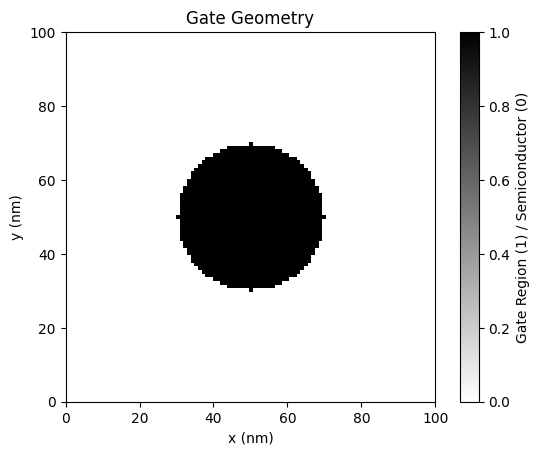

/home/daniel/grad/CMSC661/cmsc661-dev/.venv/lib/python3.11/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


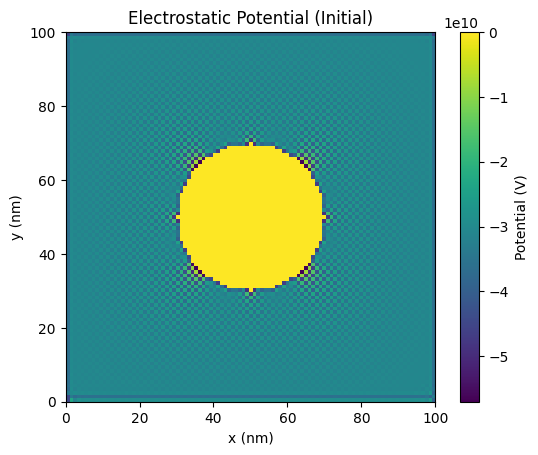

Eigenvalues (eV): [-0.49998729 -0.49999589 -0.50000109 -0.50000126 -0.50000572]


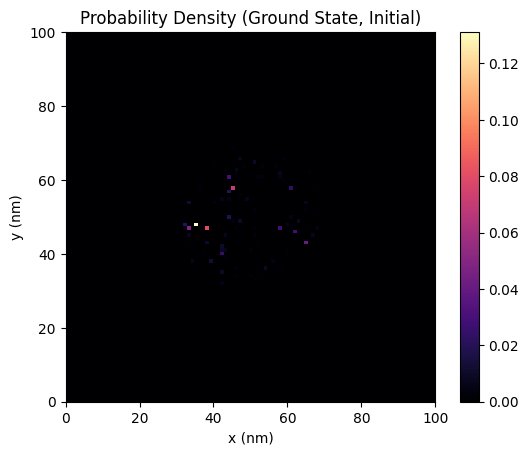

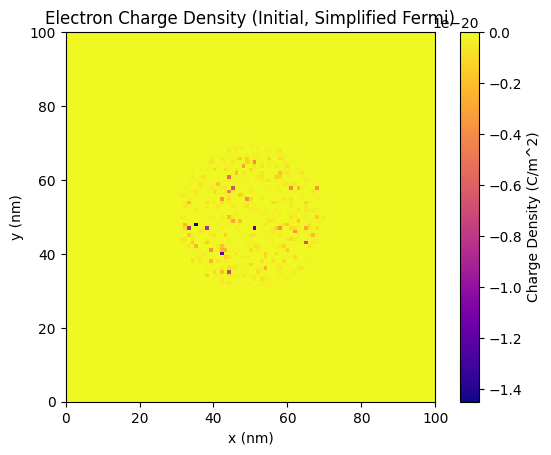

Estimated Fermi Level (eV): -0.49999824950632293


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import eigsh, spsolve
from scipy.constants import Boltzmann

# -------------------- 1. Define System Geometry and Discretization --------------------
xmin, xmax = 0, 100  # nm
ymin, ymax = 0, 100  # nm
nx = 101
ny = 101
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
dx = x[1] - x[0]
dy = y[1] - y[0]


def is_gate(xi, yi):
  center_x = (xmax + xmin) / 2
  center_y = (ymax + ymin) / 2
  radius = 20
  return (xi - center_x) ** 2 + (yi - center_y) ** 2 <= radius**2


gate_mask = np.array([[is_gate(xi, yi) for xi in x] for yi in y])

plt.imshow(
    gate_mask.T, extent=[xmin, xmax, ymin, ymax], origin='lower', cmap='gray_r'
)
plt.title("Gate Geometry")
plt.xlabel("x (nm)")
plt.ylabel("y (nm)")
plt.colorbar(label="Gate Region (1) / Semiconductor (0)")
plt.show()

# -------------------- 2. Define Material Parameters and External Potentials --------------------
effective_mass = 0.067 * 9.109e-31  # kg
epsilon_semiconductor = 12.9 * 8.854e-12  # F/m
electron_charge = -1.602e-19  # C
hbar = 1.054e-34  # J s
gate_voltage = -0.5  # V
background_doping = 1e16  # /cm^3


# -------------------- 3. Construct the Hamiltonian Matrix (Kinetic Part) --------------------
def kinetic_energy_operator_2d(nx, ny, dx, dy, mass):
  """Constructs the 2D kinetic energy operator using finite differences."""
  coeffs_x = -hbar**2 / (2 * mass * dx**2)
  coeffs_y = -hbar**2 / (2 * mass * dy**2)

  diag_x = 2 * (coeffs_x + coeffs_y) * np.ones(nx * ny)

  off_diag_x_plus = np.ones(nx * ny - 1) * coeffs_x
  off_diag_x_minus = np.ones(nx * ny - 1) * coeffs_x
  off_diag_y_plus = np.ones(nx * (ny - 1)) * coeffs_y
  off_diag_y_minus = np.ones(nx * (ny - 1)) * coeffs_y

  # Indices to remove for x+1 offset (end of each row)
  remove_plus_x = np.arange(nx - 1, nx * ny - 1, nx)
  off_diag_x_plus[remove_plus_x] = 0

  # Indices to remove for x-1 offset (beginning of each row)
  remove_minus_x = np.arange(0, nx * (ny - 1), nx)
  off_diag_x_minus[remove_minus_x] = 0

  diagonals = [
      diag_x,
      off_diag_x_plus,
      off_diag_x_minus,
      off_diag_y_plus,
      off_diag_y_minus,
  ]
  offsets = [0, 1, -1, nx, -nx]

  return diags(diagonals, offsets, shape=(nx * ny, nx * ny))


T = kinetic_energy_operator_2d(nx, ny, dx, dy, effective_mass)

# -------------------- 4. Solve the Poisson Equation (Initial) --------------------
def poisson_solver_2d(nx, ny, dx, dy, epsilon, charge_density, gate_mask, gate_voltage):
  """Solves the 2D Poisson equation using finite differences."""
  hbar = 1.054e-34  # J s
  laplacian = (
      kinetic_energy_operator_2d(nx, ny, dx, dy, 1)
      * (dx**2 * dy**2 * 2 * epsilon / (hbar**2 * (dy**2 + dx**2)))
  )  # Scaled Laplacian

  # Convert to CSR format for item assignment
  laplacian = csr_matrix(laplacian)

  b = -charge_density.flatten() / epsilon * dx**2  # Right-hand side

  # Apply boundary conditions (Dirichlet for the gate)
  boundary_indices = np.where(gate_mask.flatten())[0]
  for idx in boundary_indices:
    laplacian[idx, :] = 0
    laplacian[idx, idx] = 1
    b[idx] = gate_voltage

  potential_flat = spsolve(laplacian, b)
  return potential_flat.reshape((ny, nx))


initial_charge_density = (
    electron_charge * background_doping * 1e-6 * np.ones((ny, nx))
)  # /m^3
potential = poisson_solver_2d(
    nx, ny, dx, dy, epsilon_semiconductor, initial_charge_density, gate_mask, gate_voltage
)

plt.imshow(potential.T, extent=[xmin, xmax, ymin, ymax], origin='lower', cmap='viridis')
plt.title("Electrostatic Potential (Initial)")
plt.xlabel("x (nm)")
plt.ylabel("y (nm)")
plt.colorbar(label="Potential (V)")
plt.show()

# -------------------- 5. Solve the Schrödinger Equation (Initial) --------------------
def solve_schrodinger_2d(kinetic_op, potential_energy, num_eigenvalues=10):
  """Solves the 2D Schrödinger equation for the lowest eigenvalues and eigenvectors."""
  H = kinetic_op + diags(potential_energy.flatten(), 0, shape=kinetic_op.shape)
  eigenvalues, eigenvectors = eigsh(csr_matrix(H), k=num_eigenvalues, which='SM')
  return eigenvalues, eigenvectors.reshape((kinetic_op.shape[0], num_eigenvalues))


potential_energy = electron_charge * potential
num_eigenvalues = 5
eigenvalues, eigenvectors = solve_schrodinger_2d(T, potential_energy, num_eigenvalues)

print("Eigenvalues (eV):", eigenvalues / electron_charge)

probability_density = np.abs(eigenvectors[:, 0].reshape((ny, nx))) ** 2
plt.imshow(
    probability_density.T, extent=[xmin, xmax, ymin, ymax], origin='lower', cmap='magma'
)
plt.title("Probability Density (Ground State, Initial)")
plt.xlabel("x (nm)")
plt.ylabel("y (nm)")
plt.colorbar()
plt.show()


# -------------------- 6. Calculate the Charge Density and Fermi Level (Simplified) --------------------
def electron_density_2d(eigenvalues, eigenvectors, fermi_level, temperature):
  kbT = Boltzmann * temperature
  occupation = 1 / (1 + np.exp((eigenvalues - fermi_level) / (kbT + 1e-12)))  # Added small constant for numerical stability
  density = np.zeros(eigenvectors.shape[0])
  for i in range(eigenvalues.size):
    density += occupation[i] * np.abs(eigenvectors[:, i]) ** 2
  return density.reshape((ny, nx))


# Very simplified Fermi level estimation (you'll need a proper self-consistent loop)
fermi_level = np.mean(eigenvalues)  # eV (rough estimate)
temperature = 4.2  # K

charge_density = electron_charge * electron_density_2d(
    eigenvalues, eigenvectors, fermi_level, temperature
)

plt.imshow(
    charge_density.T, extent=[xmin, xmax, ymin, ymax], origin='lower', cmap='plasma'
)
plt.title("Electron Charge Density (Initial, Simplified Fermi)")
plt.xlabel("x (nm)")
plt.ylabel("y (nm)")
plt.colorbar(label="Charge Density (C/m^2)")
plt.show()

print("Estimated Fermi Level (eV):", fermi_level / electron_charge)

# -------------------- 7. Self-Consistent Iteration (Conceptual - Needs Full Implementation) --------------------
# In a full implementation, you would loop through steps 4-6, updating the potential
# based on the calculated charge density in each iteration, until convergence is reached.
# This simplified code only performs one pass.

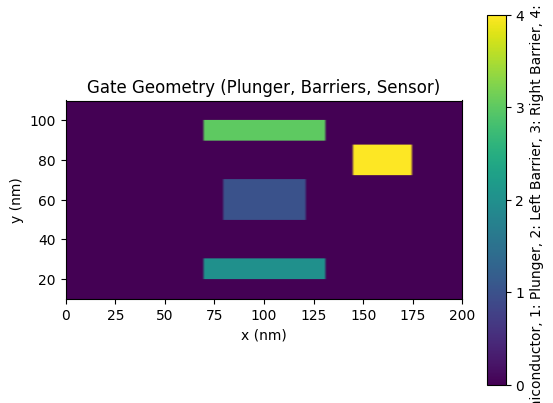

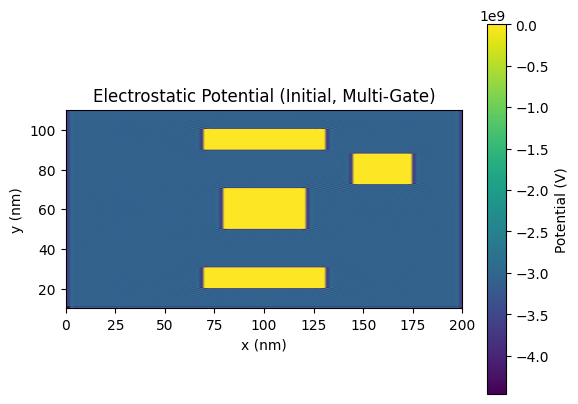

Eigenvalues (eV): [ 4.68430106e-07 -5.57821561e-09 -6.95506017e-07 -1.57481847e-06
 -1.99999282e-01]


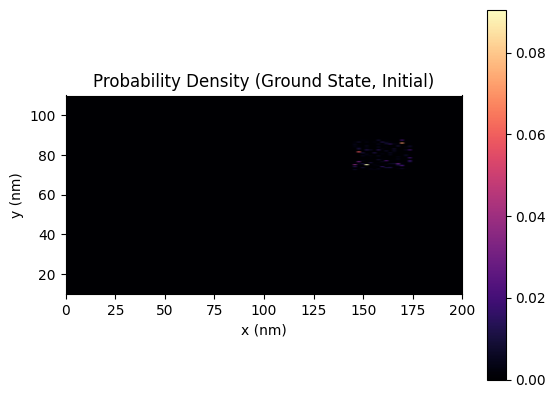

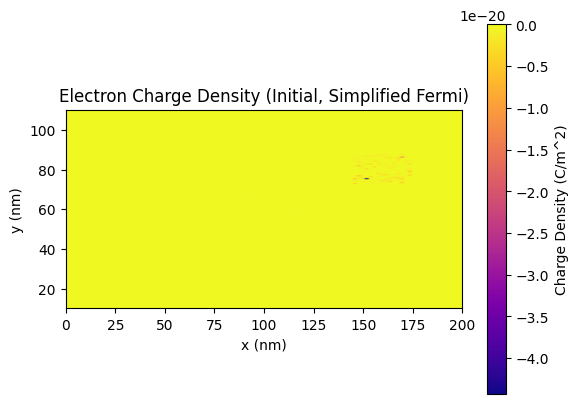

Estimated Fermi Level (eV): -0.040000217812776774


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import eigsh, spsolve
from scipy.constants import Boltzmann

# -------------------- 1. Define System Geometry and Discretization --------------------
xmin, xmax = 0, 200  # nm (larger domain to accommodate multiple gates)
ymin, ymax = 10, 110  # nm (narrower in y for 1D-like confinement)
nx = 201
ny = 101
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
dx = x[1] - x[0]
dy = y[1] - y[0]


def is_plunger(xi, yi):
    center_x = (xmax + xmin) / 2
    center_y = (ymax + ymin) / 2
    width = 40
    height = 20
    return (abs(xi - center_x) <= width / 2) and (abs(yi - center_y) <= height / 2)

def is_barrier_left(xi, yi):
    center_x = xmin + 30
    center_y = (ymax + ymin) / 2
    width = 20
    height = 30
    return (abs(xi - center_x) <= width / 2) and (abs(yi - center_y) <= height / 2)

def is_barrier_right(xi, yi):
    center_x = xmax - 30
    center_y = (ymax + ymin) / 2
    width = 20
    height = 30
    return (abs(xi - center_x) <= width / 2) and (abs(yi - center_y) <= height / 2)

def is_sensor(xi, yi):
    center_x = xmax - 60
    center_y = ymax - 20
    width = 30
    height = 15
    return (abs(xi - center_x) <= width / 2) and (abs(yi - center_y) <= height / 2)

gate_mask = np.zeros((ny, nx), dtype=int)
for i, yi in enumerate(y):
    for j, xi in enumerate(x):
        if is_plunger(xi, yi):
            gate_mask[i, j] = 1  # Plunger
        elif is_barrier_left(xi, yi):
            gate_mask[i, j] = 2  # Left Barrier
        elif is_barrier_right(xi, yi):
            gate_mask[i, j] = 3  # Right Barrier
        elif is_sensor(xi, yi):
            gate_mask[i, j] = 4  # Sensor

plt.imshow(gate_mask.T, extent=[xmin, xmax, ymin, ymax], origin='lower', cmap='viridis')
plt.title("Gate Geometry (Plunger, Barriers, Sensor)")
plt.xlabel("x (nm)")
plt.ylabel("y (nm)")
plt.colorbar(ticks=[0, 1, 2, 3, 4], label="0: Semiconductor, 1: Plunger, 2: Left Barrier, 3: Right Barrier, 4: Sensor")
plt.show()

# -------------------- 2. Define Material Parameters and Gate Voltages --------------------
effective_mass = 0.067 * 9.109e-31  # kg
epsilon_semiconductor = 12.9 * 8.854e-12  # F/m
electron_charge = -1.602e-19  # C
hbar = 1.054e-34  # J s
plunger_voltage = -0.2  # V
barrier_voltage = -0.8  # V (applied to both barriers)
sensor_voltage = 0.0  # V
background_doping = 1e15  # /cm^3 (lower doping)


# -------------------- 3. Construct the Hamiltonian Matrix (Kinetic Part) --------------------
def kinetic_energy_operator_2d(nx, ny, dx, dy, mass):
    coeffs_x = -hbar**2 / (2 * mass * dx**2)
    coeffs_y = -hbar**2 / (2 * mass * dy**2)

    diag_x = 2 * (coeffs_x + coeffs_y) * np.ones(nx * ny)

    off_diag_x_plus = np.ones(nx * ny - 1) * coeffs_x
    off_diag_x_minus = np.ones(nx * ny - 1) * coeffs_x
    off_diag_y_plus = np.ones(nx * (ny - 1)) * coeffs_y
    off_diag_y_minus = np.ones(nx * (ny - 1)) * coeffs_y

    # Remove connections across row boundaries (x-direction)
    remove_plus_x = np.arange(nx - 1, nx * ny - 1, nx)
    off_diag_x_plus[remove_plus_x] = 0
    remove_minus_x = np.arange(0, nx * (ny - 1), nx)
    off_diag_x_minus[remove_minus_x] = 0

    diagonals = [diag_x, off_diag_x_plus, off_diag_x_minus, off_diag_y_plus, off_diag_y_minus]
    offsets = [0, 1, -1, nx, -nx]

    return diags(diagonals, offsets, shape=(nx * ny, nx * ny))

T = kinetic_energy_operator_2d(nx, ny, dx, dy, effective_mass)

# -------------------- 4. Solve the Poisson Equation (Initial with Multiple Gates) --------------------
def poisson_solver_2d_multi_gate(nx, ny, dx, dy, epsilon, charge_density, gate_mask, plunger_v, barrier_v, sensor_v):
    laplacian = (
        kinetic_energy_operator_2d(nx, ny, dx, dy, 1)
        * (dx**2 * dy**2 * 2 * epsilon / (hbar**2 * (dy**2 + dx**2)))
    )
    laplacian_csr = csr_matrix(laplacian)
    b = -charge_density.flatten() / epsilon * dx**2

    boundary_indices_plunger = np.where(gate_mask.flatten() == 1)[0]
    boundary_indices_barrier = np.where((gate_mask.flatten() == 2) | (gate_mask.flatten() == 3))[0]
    boundary_indices_sensor = np.where(gate_mask.flatten() == 4)[0]

    for idx in boundary_indices_plunger:
        laplacian_csr[idx, :] = 0
        laplacian_csr[idx, idx] = 1
        b[idx] = plunger_v
    for idx in boundary_indices_barrier:
        laplacian_csr[idx, :] = 0
        laplacian_csr[idx, idx] = 1
        b[idx] = barrier_v
    for idx in boundary_indices_sensor:
        laplacian_csr[idx, :] = 0
        laplacian_csr[idx, idx] = 1
        b[idx] = sensor_v

    potential_flat = spsolve(laplacian_csr, b)
    return potential_flat.reshape((ny, nx))

initial_charge_density = (
    electron_charge * background_doping * 1e-6 * np.ones((ny, nx))
)  # /m^3
potential = poisson_solver_2d_multi_gate(
    nx, ny, dx, dy, epsilon_semiconductor, initial_charge_density, gate_mask,
    plunger_voltage, barrier_voltage, sensor_voltage
)

plt.imshow(potential.T, extent=[xmin, xmax, ymin, ymax], origin='lower', cmap='viridis')
plt.title("Electrostatic Potential (Initial, Multi-Gate)")
plt.xlabel("x (nm)")
plt.ylabel("y (nm)")
plt.colorbar(label="Potential (V)")
plt.show()

# -------------------- 5. Solve the Schrödinger Equation (Initial) --------------------
def solve_schrodinger_2d(kinetic_op, potential_energy, num_eigenvalues=10):
    H = kinetic_op + diags(potential_energy.flatten(), 0, shape=kinetic_op.shape)
    eigenvalues, eigenvectors = eigsh(csr_matrix(H), k=num_eigenvalues, which='SM')
    return eigenvalues, eigenvectors.reshape((kinetic_op.shape[0], num_eigenvalues))

potential_energy = electron_charge * potential
num_eigenvalues = 5
eigenvalues, eigenvectors = solve_schrodinger_2d(T, potential_energy, num_eigenvalues)

print("Eigenvalues (eV):", eigenvalues / electron_charge)

probability_density = np.abs(eigenvectors[:, 0].reshape((ny, nx))) ** 2
plt.imshow(
    probability_density.T, extent=[xmin, xmax, ymin, ymax], origin='lower', cmap='magma'
)
plt.title("Probability Density (Ground State, Initial)")
plt.xlabel("x (nm)")
plt.ylabel("y (nm)")
plt.colorbar()
plt.show()


# -------------------- 6. Calculate the Charge Density and Fermi Level (Simplified) --------------------
def electron_density_2d(eigenvalues, eigenvectors, fermi_level, temperature):
    kbT = Boltzmann * temperature
    occupation = 1 / (1 + np.exp((eigenvalues - fermi_level) / (kbT + 1e-12)))
    density = np.zeros(eigenvectors.shape[0])
    for i in range(eigenvalues.size):
        density += occupation[i] * np.abs(eigenvectors[:, i]) ** 2
    return density.reshape((ny, nx))

fermi_level = np.mean(eigenvalues)  # eV (rough estimate)
temperature = 4.2  # K

charge_density = electron_charge * electron_density_2d(
    eigenvalues, eigenvectors, fermi_level, temperature
)

plt.imshow(
    charge_density.T, extent=[xmin, xmax, ymin, ymax], origin='lower', cmap='plasma'
)
plt.title("Electron Charge Density (Initial, Simplified Fermi)")
plt.xlabel("x (nm)")
plt.ylabel("y (nm)")
plt.colorbar(label="Charge Density (C/m^2)")
plt.show()

print("Estimated Fermi Level (eV):", fermi_level / electron_charge)

# -------------------- 7. Self-Consistent Iteration (Conceptual) --------------------
# To fully simulate the charge sensor, you would need to:
# 1. Implement the self-consistent loop.
# 2. Calculate a property of the charge sensor (e.g., capacitance or current) that depends
#    on the charge state of the quantum dot. This typically involves more advanced
#    modeling of the sensor's electrostatics and transport properties, which is beyond
#    a simple Schrödinger-Poisson solver for the dot itself.
# 3. The change in the sensor signal would then be correlated with the change in the
#    number of electrons in the quantum dot as the plunger gate voltage is varied.